## SCM class tutorial

This tutorial gives a short overview of the SCM python base class and some if its uses.

The intended purpose of this class is to define SCMs and sample from their observational,
interventional as well as counterfactual distributions. This implementation of SCMs is meant
to be as flexible as possible. Any functional form is permitted for the mechanisms of variables,
all established probability distributions can be used to define noise terms and extremely
general types of interventions are supported. Some examples will be provided in the following.

__Please note__: this implementation of SCMs as a data generating process is a functional one.
While the functional definition of causal variables implies a graph, this is __not__ an explicit
graphical model. This feature may be added in the future.

In order to use this package as a python module, add ```SCM_gen``` to your `PYTHONPATH` environment variable.
This can be done by executing the following command in your terminal:
```
export PYTHONPATH=$PYTHONPATH:/path/to/SCM_gen
```

In [7]:
# Import SCM base class and causal variable class
from SCM_gen import SCM, CausalVar, Intervention

# Import distributions
from scipy.stats import norm, uniform

import numpy as np
import matplotlib.pyplot as plt

The `SCM` base class is an abstract class, so in order to define a concrete SCM, we must define a class which inherits from it.

Consider the following example of an SCM with three variables:

In [2]:
class test_SCM(SCM):
    def __init__(self):
        super().__init__()

    def _define_variables(self):
        # Define the variables in the correct causal ordering
        e1 = norm(0, 1)
        f1 = lambda e: e
        z1 = CausalVar(parents = None, noise_distr = e1, mechanism_fct = f1)

        e2 = uniform(0, 1)
        f2 = lambda x1, e: 4 * x1 + e
        z2 = CausalVar(parents = [z1], noise_distr = e2, mechanism_fct = f2)

        e3 = uniform(2, 3)
        f3 = lambda x1, x2, e: 3 * x1 + np.sin(x2) + e
        z3 = CausalVar(parents= [z1, z2], noise_distr = e3, mechanism_fct = f3)

        variables = (z1, z2, z3) # Must be in the correct causal ordering!

        return variables

The only thing which needs to be implemented is the `_define_variables` method, which fully specifies the SCM.
In this method, the causal variables are defined in terms of their mechanism functions, noise distributions and parents.
Each variable must be a `CausalVar` instance and take a scipy continuous distribution as noise and a callable function as mechanism.
The parents are passed as a list of other causal variables or `None` for root nodes.

Once the specific SCM is implemented as a subclass of the `SCM` base class, we can instantiate it and start playing around with it:

In [3]:
model = test_SCM()

First, let us draw a sample of size 100 from the observational distribution:

In [4]:
obs_sample = model.sample(n=1000)

We can also return the sampled noise by setting the `return_noise` argument to `True`:

In [18]:
obs_sample, obs_noise = model.sample(n=1000, return_noise=True)

Let us plot the sampled values, as well as the sampled noise:

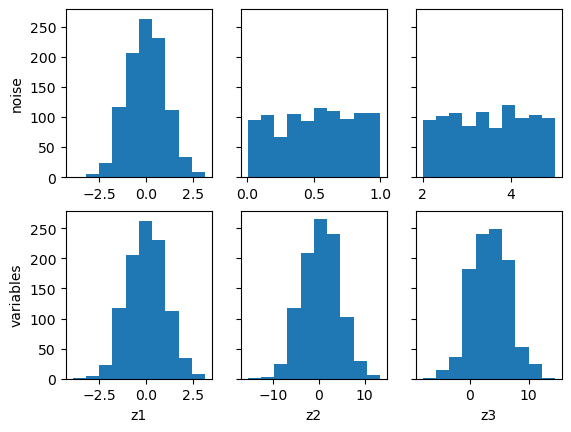

In [28]:
fig, axs = plt.subplots(2, 3, sharey=True)
n_bins = 10
axs[0, 0].hist(obs_noise[0], bins=n_bins)
axs[0, 1].hist(obs_noise[1], bins=n_bins)
axs[0, 2].hist(obs_noise[2], bins=n_bins)

axs[1, 0].hist(obs_sample[0], bins=n_bins)
axs[1, 1].hist(obs_sample[1], bins=n_bins)
axs[1, 2].hist(obs_sample[2], bins=n_bins)

axs[0, 0].set(ylabel='noise')
axs[1, 0].set(ylabel='variables')

axs[1,0].set(xlabel='z1')
axs[1,1].set(xlabel='z2')
axs[1,2].set(xlabel='z3')

plt.show()

We can also define interventions using the `Intervention` class, which we can then use to intervene on SCMs.

The `Intervention` class is designed to handle any general type of intervention including: do-interventions, soft (noise)
interventions, interventions on mechanisms, assigning new parents to variables, intervening on noise and mechanism simultaneously
and more. For detailed documentation, see the source code in `SCM.py`.

Here, we will provide examples for the basic, widely used interventions, starting with a do-intervention on variable `z1` which sets its value to 4:

In [29]:
interv_do_1 = Intervention(targets=0, new_mechanism=4)

To draw samples from the interventional distribution, use the `intervent_sample` method:

In [30]:
interv_sample = model.intervent_sample(interv_do_1, n=1000)

Calling the `intervent_sample` method prevents the internal SCM structure from being altered permanently,
meaning we can still call the `sample` method to sample from its original, observational distribution:

In [31]:
obs_sample_post_interv = model.sample(n=1000)

Plotting this distribution against the interventional distribution shows that intervening in this way
leaves the original SCM distribution intact:

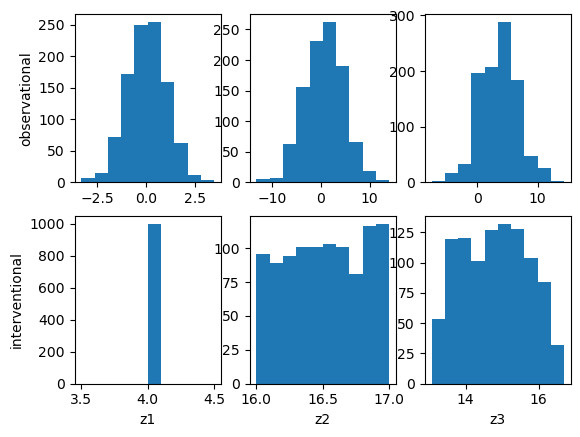

In [34]:
fig, axs = plt.subplots(2, 3)
n_bins = 10
axs[0, 0].hist(obs_sample_post_interv[0], bins=n_bins)
axs[0, 1].hist(obs_sample_post_interv[1], bins=n_bins)
axs[0, 2].hist(obs_sample_post_interv[2], bins=n_bins)

axs[1, 0].hist(interv_sample[0], bins=n_bins)
axs[1, 1].hist(interv_sample[1], bins=n_bins)
axs[1, 2].hist(interv_sample[2], bins=n_bins)

axs[0, 0].set(ylabel='observational')
axs[1, 0].set(ylabel='interventional')

axs[1,0].set(xlabel='z1')
axs[1,1].set(xlabel='z2')
axs[1,2].set(xlabel='z3')

plt.show()

If you wish to permanently change the SCM with an intervention, use `SCM`'s method `intervene`.
Sampling with the `sample` method after this will yield the same distribution as `intervent_sample`.

Let us try out and plot some other interventions.

We can also intervene on multiple targets with one `Intervention` instance. To do so,
we simply pass a list to all arguments. Let us perform a do-intervention on `z1` and `z2`:

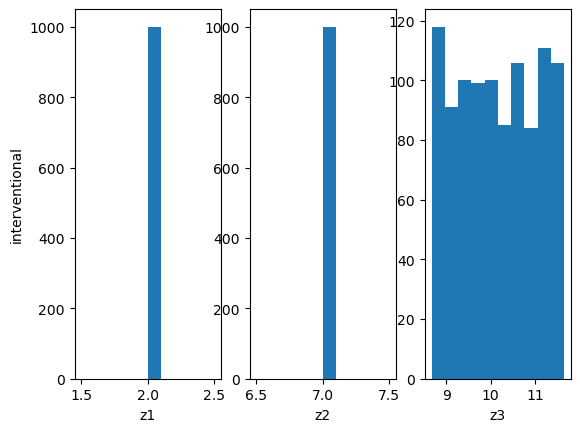

In [40]:
# Define intervention
interv_do_1_2 = Intervention(targets=[0,1], new_mechanism=[2,7])
# Intervene and sample
interv_sample_2 = model.intervent_sample(interv_do_1_2, n=1000)
# Plot
fig, axs = plt.subplots(1, 3)
n_bins = 10

axs[0].hist(interv_sample_2[0], bins=n_bins)
axs[1].hist(interv_sample_2[1], bins=n_bins)
axs[2].hist(interv_sample_2[2], bins=n_bins)

axs[0].set(ylabel='interventional')

axs[0].set(xlabel='z1')
axs[1].set(xlabel='z2')
axs[2].set(xlabel='z3')

plt.show()

A noise intervention on the noise distribution of `z2` could e.g. look like:

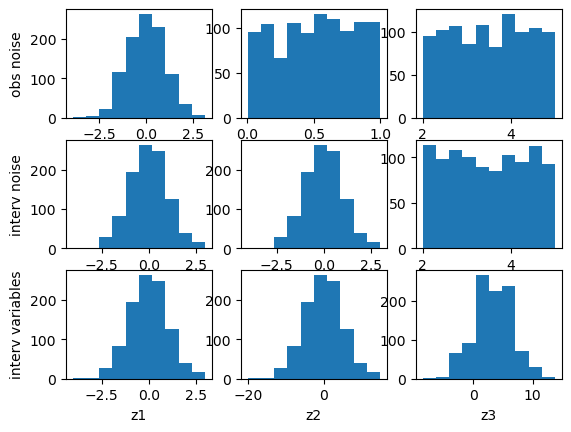

In [42]:
interv_noise_2 = Intervention(targets=1, new_noise_distr=norm(0,1))

interv_sample_3, interv_noise_sample_3 = model.intervent_sample(interv_noise_2, n=1000, return_noise=True)

fig, axs = plt.subplots(3, 3)
n_bins = 10
axs[0, 0].hist(obs_noise[0], bins=n_bins)
axs[0, 1].hist(obs_noise[1], bins=n_bins)
axs[0, 2].hist(obs_noise[2], bins=n_bins)

axs[1, 0].hist(interv_noise_sample_3[0], bins=n_bins)
axs[1, 1].hist(interv_noise_sample_3[1], bins=n_bins)
axs[1, 2].hist(interv_noise_sample_3[2], bins=n_bins)

axs[2, 0].hist(interv_sample_3[0], bins=n_bins)
axs[2, 1].hist(interv_sample_3[1], bins=n_bins)
axs[2, 2].hist(interv_sample_3[2], bins=n_bins)

axs[0, 0].set(ylabel='obs noise')
axs[1, 0].set(ylabel='interv noise')
axs[2, 0].set(ylabel='interv variables')

axs[2, 0].set(xlabel='z1')
axs[2, 1].set(xlabel='z2')
axs[2, 2].set(xlabel='z3')

plt.show()

An intervention on the mechanism of `z3` might look something like:

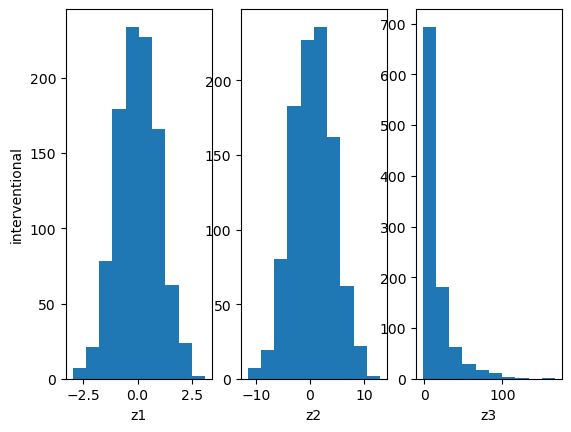

In [44]:
interv_mech_3 = Intervention(targets=2, new_mechanism=lambda x1, x2, e: 2 + np.cos(x1) + x2**2 - e, new_parents=[0, 1])

interv_sample_4 = model.intervent_sample(interv_mech_3, n=1000)

fig, axs = plt.subplots(1, 3)
n_bins = 10

axs[0].hist(interv_sample_4[0], bins=n_bins)
axs[1].hist(interv_sample_4[1], bins=n_bins)
axs[2].hist(interv_sample_4[2], bins=n_bins)

axs[0].set(ylabel='interventional')

axs[0].set(xlabel='z1')
axs[1].set(xlabel='z2')
axs[2].set(xlabel='z3')

plt.show()

We can also combine all interventions above and intervene on all variables at once with a combination of the intervention types:

/Users/Simon/Documents/PhD/Projects/SCM_gen/SCM_gen/SCM.py:117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.array(new_parents).ndim == 1:


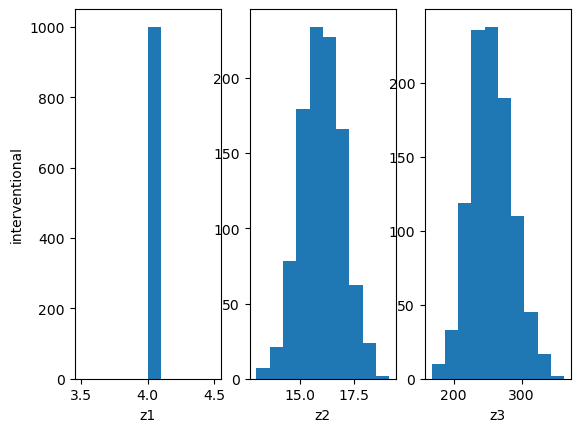

In [46]:
interv_all = Intervention(targets=[0,1,2],
                          new_mechanism=[4, None, lambda x1, x2, e: 2 + np.cos(x1) + x2**2 - e],
                          new_noise_distr=[None, norm(0,1), None],
                          new_parents=[None, None, [0, 1]])

interv_sample_5 = model.intervent_sample(interv_all, n=1000)

fig, axs = plt.subplots(1, 3)
n_bins = 10

axs[0].hist(interv_sample_5[0], bins=n_bins)
axs[1].hist(interv_sample_5[1], bins=n_bins)
axs[2].hist(interv_sample_5[2], bins=n_bins)

axs[0].set(ylabel='interventional')

axs[0].set(xlabel='z1')
axs[1].set(xlabel='z2')
axs[2].set(xlabel='z3')

plt.show()